# Word Embeddings with a language model
This model is a version of the one introduced in 2003 by Bengio et all [here](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import os

## Data wikitext-2
The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia.

The data can be dowloaded here.
`https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip`

In [3]:
PATH=Path("/data2/yinterian/wikitext-2")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/wikitext-2/model118.pth'),
 PosixPath('/data2/yinterian/wikitext-2/wiki.valid.tokens'),
 PosixPath('/data2/yinterian/wikitext-2/mode.pth'),
 PosixPath('/data2/yinterian/wikitext-2/wiki.train.tokens'),
 PosixPath('/data2/yinterian/wikitext-2/wiki.test.tokens')]

In [9]:
!head -4 /data2/yinterian/wikitext-2/wiki.train.tokens

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 


## Tokenization / get vocab

In [13]:
import spacy
tok = spacy.load('en')

In [14]:
def read_file(path):
    """ Read file returns a list of lines.
    """
    with open(path, encoding = "ISO-8859-1") as f:
        content = f.readlines()
    return content

In [19]:
train_lines = read_file(PATH/'wiki.train.tokens')
valid_lines = read_file(PATH/'wiki.valid.tokens')

In [20]:
len(train_lines), len(valid_lines)

(36718, 3760)

In [25]:
train_lines[10]

' The game \'s battle system , the <unk> system , is carried over directly from <unk> Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action <unk> . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede a character

In [29]:
from collections import defaultdict

def get_vocab(content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for line in content:
        words = set(line.split())
        for word in words:
            vocab[word] += 1
    return vocab

In [30]:
vocab = get_vocab(train_lines)

In [31]:
len(vocab)

33280

In [34]:
#vocab

## Creating a word2index

In [39]:
vocab2index = {}
words = []
for word in vocab:
    vocab2index[word] = len(words)
    words.append(word)

In [41]:
#vocab2index

## Encoding datasets

In [53]:
# there is an "unk" already
vocab2index['<unk>'] #[y for y in x for x in non_flat]

59

In [59]:
train_content = np.array([vocab2index.get(w, vocab2index["<unk>"]) for line in train_lines for w in line.split()])

In [62]:
val_content = np.array([vocab2index.get(w, vocab2index["<unk>"]) for line in valid_lines for w in line.split()])

In [63]:
train_content.shape, val_content.shape

((2051961,), (213886,))

## Dataset
Example say we have this dataset and we are using a window size of window=3.

Raw Dataset:
`the cat is walking in the bedroom`

`x                  y 
the cat is         walking 
cat is walking     in 
is walking in      the 
walking in the     bedroom` 

In [47]:
class WikiDataset(Dataset):
    def __init__(self, content, window=5):
        self.content = content
        self.window = window
        self.len = len(self.content) - self.window
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        x = self.content[idx : idx + self.window]
        y = self.content[idx + self.window]
        return x, y

In [48]:
dataset = WikiDataset([0,1,2,3,4,5,6], window=3)

In [51]:
print(len(dataset))
for i in range(4): 
    print(dataset[i])

4
([0, 1, 2], 3)
([1, 2, 3], 4)
([2, 3, 4], 5)
([3, 4, 5], 6)


In [64]:
train_ds = WikiDataset(train_content, window=5)
val_ds = WikiDataset(val_content, window=5)

In [91]:
batch_size = 2000
batch_size = 4 # testing model
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

## Model

In [104]:
class LangModel(nn.Module):
    """Lang Model that needs to be regularized."""

    def __init__(self, V, D, hidden, window=5, dropout=0.5):
        super(LangModel, self).__init__()
        self.word_emb = nn.Embedding(V, D)
        self.linear1 = nn.Linear(window*D, hidden)
        self.dense_bn1 = nn.BatchNorm1d(hidden)
        self.linear2 = nn.Linear(hidden, V)

    def forward(self, x):
        x = self.word_emb(x)
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = F.relu(self.dense_bn1(x))
        x = self.linear2(x)
        return x

In [93]:
x, y = next(iter(train_dl))

In [94]:
x, y

(tensor([[   73,  9824, 16692,  2346,    52],
         [  662,  1033,  3839,    55,   515],
         [16792,  1437,    64,   647,    10],
         [   73,  1437,  1030,  7653,    46]]),
 tensor([  346,    55,   314, 21261]))

In [95]:
V = len(vocab)
D = 3 # for testing

In [96]:
word_emb = nn.Embedding(V, D)

In [97]:
x1 = word_emb(x)
x1

tensor([[[-0.0499, -0.3318,  1.1019],
         [ 0.9620, -0.6670, -0.6020],
         [ 0.0566,  0.1635,  1.5894],
         [-0.5709,  0.7283, -1.6596],
         [ 0.1506, -1.0360, -1.4777]],

        [[ 0.8292,  0.3812,  0.0967],
         [ 1.5746,  1.1332,  0.8757],
         [ 0.0695,  0.9323,  1.2294],
         [ 0.2022, -0.0868,  0.0973],
         [ 0.2537, -0.4287,  0.2558]],

        [[ 0.0434,  0.3347,  0.6777],
         [ 1.5693,  0.1856,  2.3612],
         [ 2.6062,  0.8953,  2.3783],
         [ 0.5960,  0.4311,  1.3122],
         [-0.0049,  2.3764, -0.4857]],

        [[-0.0499, -0.3318,  1.1019],
         [ 1.5693,  0.1856,  2.3612],
         [-0.3882,  0.5207,  1.1808],
         [-0.7995,  1.2070, -0.1370],
         [ 0.5958, -0.6289,  0.9748]]], grad_fn=<EmbeddingBackward>)

In [98]:
x2 = x1.view(x1.shape[0], -1)
x2

tensor([[-0.0499, -0.3318,  1.1019,  0.9620, -0.6670, -0.6020,  0.0566,  0.1635,
          1.5894, -0.5709,  0.7283, -1.6596,  0.1506, -1.0360, -1.4777],
        [ 0.8292,  0.3812,  0.0967,  1.5746,  1.1332,  0.8757,  0.0695,  0.9323,
          1.2294,  0.2022, -0.0868,  0.0973,  0.2537, -0.4287,  0.2558],
        [ 0.0434,  0.3347,  0.6777,  1.5693,  0.1856,  2.3612,  2.6062,  0.8953,
          2.3783,  0.5960,  0.4311,  1.3122, -0.0049,  2.3764, -0.4857],
        [-0.0499, -0.3318,  1.1019,  1.5693,  0.1856,  2.3612, -0.3882,  0.5207,
          1.1808, -0.7995,  1.2070, -0.1370,  0.5958, -0.6289,  0.9748]],
       grad_fn=<ViewBackward>)

In [90]:
x2.shape

torch.Size([5, 15])

## Testing model

In [105]:
V = len(vocab)
D = 50
model = LangModel(V, D, hidden=15).cuda()

In [106]:
x, y = next(iter(train_dl))

In [107]:
x = x.cuda()

In [109]:
y_hat = model(x)

In [110]:
y_hat

tensor([[-0.1251, -0.1488, -0.2374,  ...,  0.3231, -0.0897, -0.2084],
        [ 0.2631,  0.0883,  0.5152,  ...,  0.2035, -0.1961, -0.1148],
        [ 0.0987, -0.2718,  0.0898,  ...,  0.1490,  0.0106, -0.0042],
        [ 0.3349, -0.0773,  0.1611,  ..., -0.0981,  0.0718, -0.4433]],
       device='cuda:0', grad_fn=<AddmmBackward>)

## Training

`F.cross_entropy` combines `log_softmax` and `nll_loss` in a single function.

In [112]:
batch_size = 2000
batch_size = 4 # testing model
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [126]:
def train_epocs(model, epochs=10, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for i in range(epochs):
        for x,y in train_dl:
            x = torch.LongTensor(x).cuda()
            y = torch.LongTensor(y).cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(loss.item())
    #val_metrics(model)

In [127]:
V = len(vocab)
D = 50
model = LangModel(V, D, hidden=15).cuda()

In [ ]:
train_epocs(model, epochs=10, lr=0.01)

## Learning rate finder

In [32]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_data, lr_low=1e-3, lr_high=10, epochs=2):
    losses = []
    (train_data.size(0) - 1)//bptt + 1
    iterations = epochs * ((train_data.size(0) - 1)//bptt + 1)
    delta = (lr_high - lr_low)/(iterations-1)
    losses = []
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    total_loss = 0
    ntokens = len(corpus.dictionary)
    for i in range(epochs):
        hidden = model.init_hidden(batch_size)
        for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
            lr = lrs[ind]
            data, targets = get_batch(train_data, i, bptt)
        
            hidden = Variable(hidden.data) #.detach()
            model.zero_grad()
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, ntokens), targets)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            losses.append(loss.data[0])
            ind += 1
    return lrs, losses 

In [33]:
len(corpus.dictionary)

33279

In [129]:
nemb = 300
nhid = 300
nlayers = 2
ntokens = len(corpus.dictionary)
model = RNNModel(ntokens, nemb, nhid, nlayers).cuda()
lrs, losses = LR_range_finder(model, train_data)

In [126]:
len(lrs)

5968

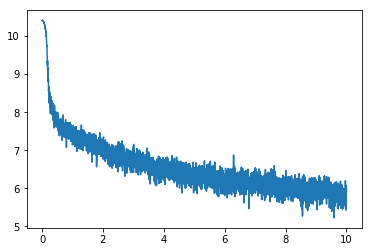

In [130]:
import matplotlib.pyplot as plt 
plt.plot(lrs, losses)
plt.show()

In [34]:
def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

## Training

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(batch_size)
    for i in range(0, data_source.size(0) - 1, bptt):
        data, targets = get_batch(data_source, i, bptt, evaluation=True)
        output, hidden = model(data, hidden)
        output_flat = output.view(-1, ntokens)
        total_loss += len(data) * criterion(output_flat, targets).data
        hidden = Variable(hidden.data) #.detach()
    return total_loss[0] / len(data_source)

In [37]:
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    return Variable(h.data)

In [38]:
import time
import math
bptt = 35
clip = 0.25

def get_batch(source, i, bptt, evaluation=False):
    seq_len = min(bptt, len(source) - 1 - i)
    data = Variable(source[i:i+seq_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+seq_len].view(-1))
    return data, target
    
def train_triangular_policy(model, epochs=4, lr_low=1e-4, lr_high=4):
    # Turn on training mode which enables dropout.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    iterations = epochs * ((train_data.size(0) - 1)//bptt + 1)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    idx = 0
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        start_time = time.time()
        hidden = model.init_hidden(batch_size)
        for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
            lr = lrs[idx]
            data, targets = get_batch(train_data, i, bptt)
            # Starting each batch, we detach the hidden state from how it was previously produced.
            # If we didn't, the model would try backpropagating all the way to start of the dataset.
            hidden = Variable(hidden.data) #.detach()
            model.zero_grad()
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, ntokens), targets)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            total_loss += len(data)*loss.data
            idx += 1
        # results after each epoch
        val_loss = evaluate(val_data)
        elapsed = time.time() - start_time
        train_loss = total_loss[0]/len(train_data)
        print('| epoch {:3d} | lr {:02.5f} | t_loss {:5.2f} | t_ppl {:5.2f} | v_loss {:5.2f} | v_ppl {:5.2f}'.format(
             epoch, lr, train_loss, math.exp(train_loss), val_loss, math.exp(val_loss)))

In [39]:
steps = 10
nemb = 300
nhid = 300
nlayers = 2
ntokens = len(corpus.dictionary)
model = RNNModel(ntokens, nemb, nhid, nlayers).cuda()

In [40]:
ntokens

33279

In [41]:
train_triangular_policy(model, epochs=4, lr_low=4, lr_high=10)

| epoch   0 | lr 8.28489 | t_loss  6.52 | t_ppl 676.54 | v_loss  5.88 | v_ppl 356.71
| epoch   1 | lr 7.42878 | t_loss  5.81 | t_ppl 334.17 | v_loss  5.46 | v_ppl 234.26
| epoch   2 | lr 4.63954 | t_loss  5.47 | t_ppl 237.65 | v_loss  5.29 | v_ppl 198.54
| epoch   3 | lr 4.00000 | t_loss  5.30 | t_ppl 200.86 | v_loss  5.21 | v_ppl 182.89


In [42]:
train_triangular_policy(model, epochs=4, lr_low=4, lr_high=10)

| epoch   0 | lr 8.28489 | t_loss  5.23 | t_ppl 186.70 | v_loss  5.25 | v_ppl 191.28
| epoch   1 | lr 7.42878 | t_loss  5.21 | t_ppl 183.43 | v_loss  5.15 | v_ppl 173.28
| epoch   2 | lr 4.63954 | t_loss  5.05 | t_ppl 155.99 | v_loss  5.05 | v_ppl 156.07
| epoch   3 | lr 4.00000 | t_loss  4.95 | t_ppl 141.00 | v_loss  5.01 | v_ppl 150.53


In [43]:
train_triangular_policy(model, epochs=4, lr_low=2, lr_high=8)

| epoch   0 | lr 6.28489 | t_loss  4.89 | t_ppl 133.02 | v_loss  5.03 | v_ppl 152.95
| epoch   1 | lr 5.42878 | t_loss  4.92 | t_ppl 137.17 | v_loss  5.01 | v_ppl 150.15
| epoch   2 | lr 2.63954 | t_loss  4.81 | t_ppl 122.90 | v_loss  4.95 | v_ppl 140.68
| epoch   3 | lr 2.00000 | t_loss  4.75 | t_ppl 115.03 | v_loss  4.92 | v_ppl 136.56


In [44]:
train_triangular_policy(model, epochs=4, lr_low=1, lr_high=6)

| epoch   0 | lr 4.57074 | t_loss  4.72 | t_ppl 111.86 | v_loss  4.96 | v_ppl 142.24
| epoch   1 | lr 3.85731 | t_loss  4.75 | t_ppl 116.10 | v_loss  4.93 | v_ppl 138.41
| epoch   2 | lr 1.53295 | t_loss  4.68 | t_ppl 107.77 | v_loss  4.89 | v_ppl 132.51
| epoch   3 | lr 1.00000 | t_loss  4.64 | t_ppl 103.22 | v_loss  4.88 | v_ppl 131.12


In [45]:
train_triangular_policy(model, epochs=4, lr_low=1, lr_high=6)

| epoch   0 | lr 4.57074 | t_loss  4.63 | t_ppl 102.69 | v_loss  4.94 | v_ppl 139.68
| epoch   1 | lr 3.85731 | t_loss  4.68 | t_ppl 107.69 | v_loss  4.91 | v_ppl 135.64
| epoch   2 | lr 1.53295 | t_loss  4.61 | t_ppl 100.48 | v_loss  4.88 | v_ppl 131.01
| epoch   3 | lr 1.00000 | t_loss  4.57 | t_ppl 96.27 | v_loss  4.86 | v_ppl 128.77


In [46]:
train_triangular_policy(model, epochs=4, lr_low=1, lr_high=6)

| epoch   0 | lr 4.57074 | t_loss  4.57 | t_ppl 96.16 | v_loss  4.94 | v_ppl 139.16
| epoch   1 | lr 3.85731 | t_loss  4.62 | t_ppl 101.75 | v_loss  4.90 | v_ppl 134.75
| epoch   2 | lr 1.53295 | t_loss  4.55 | t_ppl 94.81 | v_loss  4.87 | v_ppl 130.20
| epoch   3 | lr 1.00000 | t_loss  4.51 | t_ppl 90.76 | v_loss  4.84 | v_ppl 126.99


In [47]:
train_triangular_policy(model, epochs=4, lr_low=0.5, lr_high=4)

| epoch   0 | lr 2.99952 | t_loss  4.50 | t_ppl 89.72 | v_loss  4.87 | v_ppl 130.73
| epoch   1 | lr 2.50012 | t_loss  4.53 | t_ppl 92.41 | v_loss  4.87 | v_ppl 130.96
| epoch   2 | lr 0.87306 | t_loss  4.48 | t_ppl 88.63 | v_loss  4.85 | v_ppl 127.19
| epoch   3 | lr 0.50000 | t_loss  4.46 | t_ppl 86.83 | v_loss  4.83 | v_ppl 124.72


In [48]:
train_triangular_policy(model, epochs=4, lr_low=0.01, lr_high=4)

| epoch   0 | lr 2.85945 | t_loss  4.46 | t_ppl 86.33 | v_loss  4.88 | v_ppl 131.15
| epoch   1 | lr 2.29014 | t_loss  4.49 | t_ppl 89.12 | v_loss  4.86 | v_ppl 129.46
| epoch   2 | lr 0.43529 | t_loss  4.46 | t_ppl 86.08 | v_loss  4.81 | v_ppl 122.88
| epoch   3 | lr 0.01000 | t_loss  4.47 | t_ppl 86.95 | v_loss  4.77 | v_ppl 118.41


In [49]:
train_triangular_policy(model, epochs=4, lr_low=0.01, lr_high=3)

| epoch   0 | lr 2.14531 | t_loss  4.43 | t_ppl 83.85 | v_loss  4.86 | v_ppl 129.56
| epoch   1 | lr 1.71867 | t_loss  4.45 | t_ppl 85.22 | v_loss  4.86 | v_ppl 128.80
| epoch   2 | lr 0.32870 | t_loss  4.43 | t_ppl 83.67 | v_loss  4.81 | v_ppl 122.69
| epoch   3 | lr 0.01000 | t_loss  4.44 | t_ppl 85.17 | v_loss  4.77 | v_ppl 117.78


In [50]:
train_triangular_policy(model, epochs=4, lr_low=0.001, lr_high=2)

| epoch   0 | lr 1.42858 | t_loss  4.41 | t_ppl 82.25 | v_loss  4.84 | v_ppl 126.83
| epoch   1 | lr 1.14335 | t_loss  4.41 | t_ppl 82.16 | v_loss  4.83 | v_ppl 125.69
| epoch   2 | lr 0.21407 | t_loss  4.41 | t_ppl 81.95 | v_loss  4.79 | v_ppl 120.86
| epoch   3 | lr 0.00100 | t_loss  4.44 | t_ppl 84.46 | v_loss  4.77 | v_ppl 117.45


In [51]:
def save_model(m, p):
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    m.load_state_dict(torch.load(p))

p = PATH/"mode117.pth"
save_model(model, str(p))

In [13]:
p = PATH/"mode117.pth"
print(p)

/data/yinterian/wikitext-2/mode117.pth


## References
* https://github.com/pytorch/examples/tree/master/word_language_model
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/